In NLP most of the data is raw text. The tokenizer is used to transform raw text to numbers. Models can only process numbers, so tokenizers need to convert our text inputs to numerical data. The goal is to find the most **meaningful representation** — that is, the one that makes the most sense to the model — and, if possible, the smallest representation.

The goal when crafting the vocabulary is to do it in such a way that the tokenizer tokenizes as **few words as possible into the unknown token, and the vocabulary is as small as possible**.

Let’s take a look at some examples of tokenization algorithms.

# Word-based tokenization

Splitting the raw text into words by using the spaces or other specific rules, such as punctuation marks. This is called word-based tokenization.

Each word has a specific ID. The model has representations based on entire words, the information held in a singles number is high, as a word contains a lot of contextual and semantic information in a sentence.

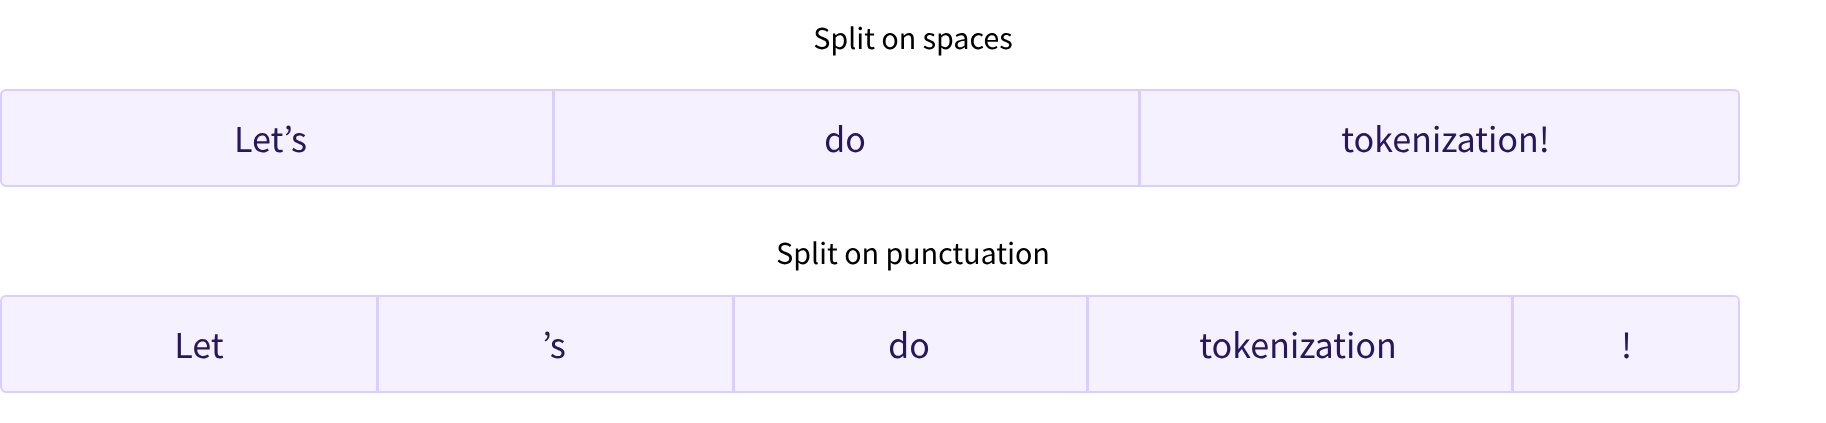

However this approach does have its limits. For example, similar words like 'dog' and 'dogs' with similar meanings. The word-based tokenization will assign **entirely different IDs** to these words, and therefore the model will learn different embeddings for them identifying the two words as unrelated. This can lead to a loss of information.

Additionally, the **vocabulary size can be very large**, which can make the model slow to train and consume a lot of memory. We could limit the amount of words we add to the vocabulary to most frequent words, but this can lead to a loss of information.

# Character-based tokenization

Character-based tokenizers split the text into characters, rather than words. This has two primary benefits:

- The vocabulary is much smaller.
- There are much fewer out-of-vocabulary (unknown) tokens, since every word can be built from characters.

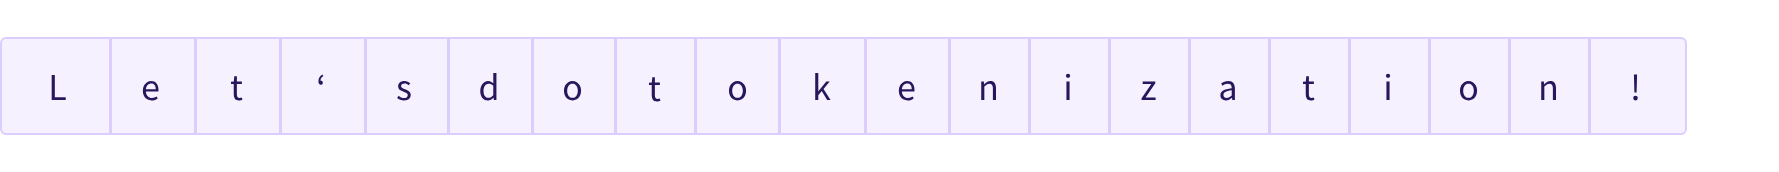

This approach isn’t perfect either. Since the representation is now based on characters rather than words, one could argue that, intuitively, it’s **less meaningful**: each character doesn’t mean a lot on its own, whereas that is the case with words.

Another thing to consider is that we’ll end up with a **very large amount of tokens** to be processed by our model: whereas a word would only be a single token with a word-based tokenizer, it can easily turn into 10 or more tokens when converted into characters.

# Subword-based tokenization

Subword tokenization algorithms rely on the principle that **frequently used words should not be split into smaller subwords, but rare words should be decomposed into meaningful subwords**.

For instance, “annoyingly” might be considered a rare word and could be decomposed into “annoying” and “ly”. These are both likely to appear more frequently as standalone subwords, while at the same time the meaning of “annoyingly” is kept by the composite meaning of “annoying” and “ly”.

Here is an example showing how a subword tokenization algorithm would tokenize the sequence “Let’s do tokenization!“:

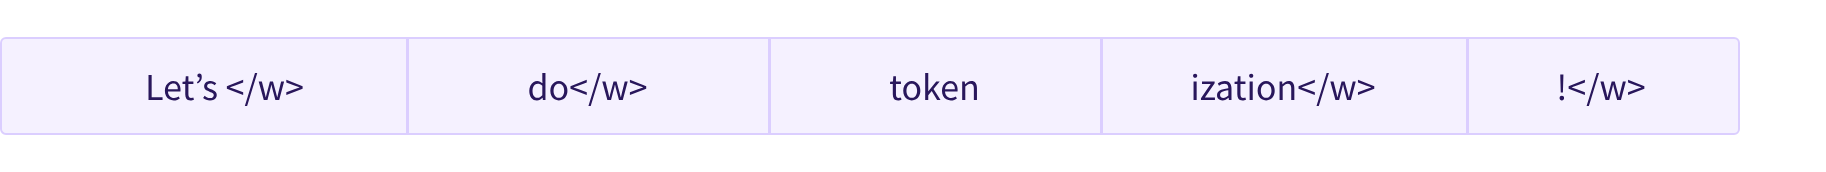

These subwords end up **providing a lot of semantic meaning**: for instance, in the example above “tokenization” was split into “token” and “ization”, two tokens that have a semantic meaning **while being space-efficient** (only two tokens are needed to represent a long word). This allows us to have relatively good coverage with small vocabularies, and close to no unknown tokens.

There are many more techniques out there. To name a few:

- Byte-level BPE, as used in GPT-2
- WordPiece, as used in BERT
- SentencePiece or Unigram, as used in several multilingual models

# Loading and saving

Loading and saving tokenizers is as simple as it is with models. Actually, it’s based on the same two methods: `from_pretrained()` and `save_pretrained()`. These methods will load or save the algorithm used by the tokenizer (a bit like the architecture of the model) as well as its vocabulary (a bit like the weights of the model).

Loading the BERT tokenizer trained with the same checkpoint as BERT is done the same way as loading the model, except we use the `BertTokenizer` class. Similar to AutoModel, the `AutoTokenizer` class will grab the proper tokenizer class in the library based on the checkpoint name, and can be used directly with any checkpoint:

In [1]:
#from transformers import BertTokenizer
from transformers import AutoTokenizer

#tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

We can now use the tokenizer:

In [2]:
tokenizer("Using a Transformer network is simple")

{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [7]:
tokenizer.decode(tokenizer("Using a Transformer network is simple")["input_ids"])

'[CLS] Using a Transformer network is simple [SEP]'

Saving a tokenizer is identical to saving a model:

In [3]:
tokenizer.save_pretrained("tmp")

('tmp/tokenizer_config.json',
 'tmp/special_tokens_map.json',
 'tmp/vocab.txt',
 'tmp/added_tokens.json',
 'tmp/tokenizer.json')

# Breaking Encoding

Translating text to numbers is known as encoding. Encoding is done in a two-step process: the tokenization, followed by the conversion to input IDs.

As we’ve seen, the first step is to split the text into words (or parts of words, punctuation symbols, etc.), usually called `tokens`. There are multiple rules that can govern that process, which is why we need to instantiate the tokenizer using the name of the model, to make sure we use the same rules that were used when the model was pretrained.

The second step is to convert those tokens into numbers, so we can build a tensor out of them and feed them to the model. To do this, the tokenizer has a `vocabulary`, which is the part we download when we instantiate it with the `from_pretrained()` method. Again, we need to use the same vocabulary used when the model was pretrained.

## 1. Tokenize

The tokenization process is done by the tokenize() method of the tokenizer:

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence, add_special_tokens=True)

print(tokens)

['[CLS]', 'Using', 'a', 'Trans', '##former', 'network', 'is', 'simple', '[SEP]']


This tokenizer is a subword tokenizer: it splits the words until it obtains tokens that can be represented by its vocabulary. That’s the case here with transformer, which is split into two tokens: transform and ##er.

## 2. From tokens to input IDs

The conversion to input IDs is handled by the `convert_tokens_to_ids()` tokenizer method:

In [14]:
ids = tokenizer.convert_tokens_to_ids(tokens)

print(ids)

[101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102]


# Decoding

Decoding is going the other way around: from vocabulary indices, we want to get a string. This can be done with the `decode()` method as follows:

In [16]:
decoded_string = tokenizer.decode(ids)
print(decoded_string)

[CLS] Using a Transformer network is simple [SEP]


Note that the decode method not only converts the indices back to tokens, but also groups together the tokens that were part of the same words to produce a readable sentence. This behavior will be extremely useful when we use models that predict new text (either text generated from a prompt, or for sequence-to-sequence problems like translation or summarization).

Also, following this flow check how the special tokens where added into the encoded sentence. This is because the tokenizer has a `add_special_tokens` argument that can be set to True to add the special tokens (or we just can call the `tokenizer` object as at the beginning of the notebook).

# Handling multiple sequences

- How do we handle multiple sequences?
- How do we handle multiple sequences of different lengths?
- Are vocabulary indices the only inputs that allow a model to work well?
- Is there such a thing as too long a sequence?

In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

## Padding the inputs

Models expect a batch of inputs. Batching is the act of sending multiple sentences through the model, all at once. If you only have one sentence, you can just build a batch with a single sequence:

Batching allows the model to work when you feed it **multiple sentences**. Using multiple sequences is just as simple as building a batch with a single sequence. There’s a second issue, though. When you’re trying to batch together two (or more) sentences, they might be of **different lengths**. If you’ve ever worked with tensors before, you know that they need to be of rectangular shape, so you won’t be able to convert the list of input IDs into a tensor directly. To work around this problem, we usually `pad` the inputs.

**Padding makes sure all our sentences have the same length** by adding a special word called the `padding token` to the sentences with fewer values. For example, if you have 10 sentences with 10 words and 1 sentence with 20 words, padding will ensure all the sentences have 20 words. The padding token ID can be found in `tokenizer.pad_token_id`.

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

In [21]:
print(model(torch.tensor(sequence1_ids)).logits)

tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)


In [22]:
print(model(torch.tensor(sequence2_ids)).logits)

tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)


In [23]:
print(model(torch.tensor(batched_ids)).logits)

tensor([[ 1.5694, -1.3895],
        [ 1.3374, -1.2163]], grad_fn=<AddmmBackward0>)


See how the model outputs **different logits** for sequence two when using the ids without padding and when using the ids with padding. The model outputs the same logits for the first sequence with and without padding.


## Attention masks

If we use the input ids generated by padding manually the sentences and perform the inference, **we will get wrong predictions!** This is because the key feature of Transformer models is attention layers that contextualize each token. These will take into account the padding tokens since they attend to all of the tokens of a sequence. To get the same result when passing individual sentences of different lengths through the model or when passing a batch with the same sentences and padding applied, we need to tell those attention layers to ignore the padding tokens. This is done by using an attention mask.

Attention masks are tensors with the exact same shape as the input IDs tensor, filled with 0s and 1s:
- 1s indicate the corresponding tokens should be attended to.
- 0s indicate the corresponding tokens should not be attended to (i.e., they should be ignored by the attention layers of the model).

In [25]:
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

attention_mask = [
    [1, 1, 1],
    [1, 1, 0],
]

outputs = model(
    torch.tensor(batched_ids),
    attention_mask=torch.tensor(attention_mask)
)
print(outputs.logits)

tensor([[ 1.5694, -1.3895],
        [ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)


Now the outputs for the second sequence, the padded one, is similar when we don't use padding.

Notice how the last value of the second sequence is a padding ID, which is a 0 value in the attention mask.

# Putting it all together

We’ve been trying our best to do most of the work by hand. We’ve explored how tokenizers work and looked at tokenization, conversion to input IDs, padding, truncation, and attention masks.

However, the Hugging Face Transformers API can handle all of this for us with a high-level function that we’ll dive into here. When you call your `tokenizer` directly on the sentence, you get back inputs that are ready to pass through your model.

In [28]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequences = [
    "I love pizza",
    "I'm a software engineer",
]

model_inputs = tokenizer(sequences)
model_inputs

{'input_ids': [[101, 1045, 2293, 10733, 102], [101, 1045, 1005, 1049, 1037, 4007, 3992, 102]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}

Here, the **model_inputs variable contains everything that’s necessary for a model to operate well**. For DistilBERT, that includes the input IDs as well as the attention mask. Other models that accept additional inputs will also have those output by the tokenizer object.

This method is very powerful. It can pad according to several objectives:

In [29]:
# Will pad the sequences up to the maximum sequence length
model_inputs = tokenizer(sequences, padding="longest")

# Will pad the sequences up to the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, padding="max_length")

# Will pad the sequences up to the specified max length
model_inputs = tokenizer(sequences, padding="max_length", max_length=8)

It can also truncate sequences:

In [30]:
# Will truncate the sequences that are longer than the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, truncation=True)

# Will truncate the sequences that are longer than the specified max length
model_inputs = tokenizer(sequences, max_length=8, truncation=True)

## Special Tokens

If we take a look at the input IDs returned by the tokenizer, we will see they are a tiny bit different from what we had earlier:

In [32]:
sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
print(model_inputs["input_ids"])

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102]
[1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012]


One token ID was added at the beginning, and one at the end. Let’s decode the two sequences of IDs above to see what this is about:

In [33]:
print(tokenizer.decode(model_inputs["input_ids"]))
print(tokenizer.decode(ids))

[CLS] i've been waiting for a huggingface course my whole life. [SEP]
i've been waiting for a huggingface course my whole life.


The tokenizer added the special word `[CLS]` at the beginning and the special word `[SEP]` at the end. This is because the model was pretrained with those, so to get the same results for inference we need to add them as well. Note that some models don’t add special words, or add different ones; models may also add these special words only at the beginning, or only at the end. In any case, **the tokenizer knows which ones are expected and will deal with this for you**.